<a href="https://colab.research.google.com/github/aamini/introtodeeplearning_labs/blob/2019/lab2/Lab2_Part2_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratory 2 : Computer Vision

# Part 2: De-Biasing Facial Detection Systems

In the second portion of the lab, we'll explore two prominent aspects of applied deep learning: facial detection and algorithmic bias. 

Deploying fair, unbiased AI systems is critical to their long-term acceptance. Consider the task of facial detection: given an image, is it an image of a face? [Recent work from the MIT Media Lab](http://proceedings.mlr.press/v81/buolamwini18a/buolamwini18a.pdf) showed that this seemingly simple, but extremely important, task is subject to extreme amounts of algorithmic bias among select demographics. [Another report](https://ieeexplore.ieee.org/document/6327355) analyzed the face detection system used by the US law enforcement and found that it had significantly lower accuracy among dark skinned women between the age of 18-30 years old. 

Run the next code block for a short video from Google that explores how and why it's important to consider bias when thinking about machine learning:

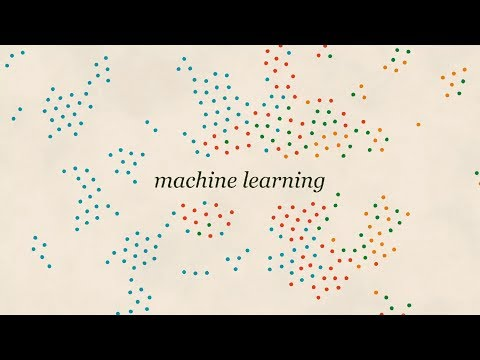

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('59bMh59JQDo')

In this lab, we'll investigate one recently published approach to address algorithmic bias. We'll build a facial detection model that learns the *latent variables* underlying face image datasets and uses this to adaptively re-sample the training data, thus mitigating any biases that may be present to train a *debiased* model.

Let's get started by installing the relevant dependencies:

In [0]:
import tensorflow as tf
tf.enable_eager_execution()
import matplotlib.pyplot as plt
import numpy as np
import h5py 
import functools
# import utile file

In [0]:
# TODO: move this to a util file
def custom_progress_text(message): 
  import progressbar
  from string import Formatter
  
  message_ = message.replace('(', '{')
  message_ = message_.replace(')', '}')

  keys = [key[1] for key in Formatter().parse(message_)]

  ids = {}
  for key in keys:
    if key is not None: 
      ids[key] = float('nan')
      
  msg = progressbar.FormatCustomText(message, ids)
  return msg

def create_progress_bar(text=None):
  import progressbar
  if text is None: 
    text = progressbar.FormatCustomText('')
  bar = progressbar.ProgressBar(widgets=[
      progressbar.Percentage(),
      progressbar.Bar(),
      progressbar.AdaptiveETA(), '  ',
      text,
  ])
  return bar

## 2.1 Datasets

We'll be using three datasets in this lab. In order to train our facial detection models, we'll need a dataset of positive examples (i.e., of faces) and a dataset of negative examples (i.e., of things that are not faces). We'll use these data to train our models to classify images as either faces or not faces. Finally, we'll need a test dataset of face images. Since we're concerned about the potential *bias* of our learned models against certain demographics, it's important that the test dataset we use has equal representation across the demographics or features of interest. We'll specifically be looking at skin tone and gender. 


1.   Positive training data: [CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). A large-scale (over 200K images) of celebrity faces.   
2.   Negative training data: [ImageNet](http://www.image-net.org/). Many images across many different categories. We'll take negative examples from a variety of non-human categories. 
3. Test data: [Pilot Parliaments Benchmark](http://proceedings.mlr.press/v81/buolamwini18a/buolamwini18a.pdf) (PPB). Images of parliamentarians from three African countries and three European countries, selected for parity across gender and skin tone. 



Let's begin by importing these datasets: 

In [0]:
# Get the training data: both images from CelebA and ImageNet
path_to_trainingdata = tf.keras.utils.get_file('celeba.h5', 'http://deep-amini.ddns.net/celeba_aligned_cache_big_crop.h5')

This directly downloads the raw data. We've written functions that do a bit of pre-processing and import the data into a usable format: 

In [0]:
# TODO: similar dataset loader for the PPB dataset
# TODO: move to util

class TrainingDatasetLoader(object):
    def __init__(self, data_path):
        self.cache = h5py.File(data_path, 'r')

        self.images = self.cache['images'][::3]
        self.labels = self.cache['labels'][::3]
        self.image_dims = self.images.shape
        n = self.image_dims[0]

        # TODO: REMOVE SPLIT
        train_test_split = 0.8 
        n_train_samples = int(train_test_split*n)
        shuffle_inds = np.random.permutation(np.arange(n))
        self.train_inds = shuffle_inds[: n_train_samples]

        self.pos_train_inds = self.train_inds[ self.labels[self.train_inds, 0] == 1.0 ]
        self.neg_train_inds = self.train_inds[ self.labels[self.train_inds, 0] != 1.0 ]

    def get_train_size(self):
        return self.train_inds.shape[0]

    def get_batch(self, n, only_faces=False, p_pos=None, p_neg=None, return_inds=False):
        if only_faces: 
          selected_inds = np.random.choice(self.pos_train_inds, size=n, replace=False, p=p_pos)
        else: 
          selected_pos_inds = np.random.choice(self.pos_train_inds, size=n//2, replace=False, p=p_pos)
          selected_neg_inds = np.random.choice(self.neg_train_inds, size=n//2, replace=False, p=p_neg)
          selected_inds = np.concatenate((selected_pos_inds, selected_neg_inds))
          
        sorted_inds = np.sort(selected_inds)
        train_img = self.images[sorted_inds,:,:,::-1]/255.
        train_label = self.labels[sorted_inds,...]
        return (train_img, train_label, sorted_inds) if return_inds else (train_img, train_label)

    def get_n_most_prob_faces(self, prob, n):
        idx = np.argsort(prob)[::-1]
        most_prob_inds = self.pos_train_inds[idx[:10*n:10]]
        return self.images[most_prob_inds,...]/255.

    def get_all_train_faces(self):
        return self.images[ self.pos_train_inds ]

Let's create a `TrainingDatasetLoader` and use it to take a look at the training data:

In [0]:
# Instantiate a TrainingDatasetLoader using the downloaded dataset
loader = TrainingDatasetLoader(path_to_celeba)

We can look at the size of the training dataset and grab a batch of size 100:

In [0]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

Play around with displaying images to get a sense of what the training data actually looks like!

In [0]:
#@title Change the sliders to look at positive and negative training examples! { run: "auto" }

face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 22 #@param {type:"slider", min:0, max:50, step:1}
idx_not_face = 36 #@param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(4,2))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face")
plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face")
plt.grid(False)

We can also create a `TestDatasetLoader` for the PPB dataset and take a look at this data:

In [0]:
# TODO loader for PPB, plus code for displaying some images

As you can see, the PPB dataset is quite balanced in terms of the skin tone and gender across the set of displayed images. Do you notice any trends or patterns in the images from the CelebA dataset? Do you anticipate any potential issues in terms of classification performance for models trained on CelebA and then tested on a dataset like PPB?

### Thinking about bias

Remember that in this lab we'll be training our facial detection classifiers on the large, well-curated CelebA dataset (and ImageNet), and then evaluating their accuracy by testing them on the PPB dataset. Our goal is to build a model that trains on CelebA *and* achieves high classification accuracy on PPB across all demographics, and to thus show that this model does not suffer from any hidden bias. 

What exactly do we mean if we say a classifier is biased? In order to formalize this, we'll need to think about [*latent variables*](https://en.wikipedia.org/wiki/Latent_variable), variables that define a dataset but are not strictly observed. We can think of a classifier as *biased* if its classification decision changes after it sees some additional latent features. This notion of bias will be helpful to keep in mind throughout the rest of the lab. 

## 2.2 CNN for facial detection 

First, we'll define and train a CNN on the facial classification task, and evaluate its accuracy on the PPB dataset. Later, we'll evaluate the performance of our debiased models against this baseline CNN. The model architecture is shown here:

![CNN model](https://raw.githubusercontent.com/aamini/introtodeeplearning_labs/2019/lab2/img/mnist_model.png)
TODO: update the architecture figure

### Define and train the CNN model

Like we did in the first part of the lab, we'll define our CNN model, and then train on the CelebA and ImageNet datasets using the `tf.GradientTape` class and the `tf.GradientTape.gradient` method:

In [0]:
# TODO: block here for defining the CNN model and running the training loop

### Evaluate performance on the PPB dataset

Next, let's evaluate the classification performance of our CelebA-trained CNN on the PPB dataset. We'll look at the classification accuracy across four different demographics defined in PPB: dark-skinned male, dark-skinned female, light-skinned male, and light-skinned female.

In [0]:
# TODO: block here for testing the CNN on PPB
# include a function that returns / plots the accuracy on the four different demographics in PPB

Take a look at the accuracies for this first model across these four groups. What do you observe? Would you consider this model biased or unbiased, and why? 

## 2.3 Variational autoencoder (VAE) for learning latent structure

As you saw, the accuracy of the CNN varies across the four demographics we looked at, performing worse on images of dark-skinned males in particular. To think about why this may be, consider the dataset the model was trained on, CelebA. If certain features, such as dark skin or hats, are *rare* in CelebA, the model may end up biased against these; that is, its classification accuracy will be worse on dark-skinned faces or faces with hats relevative to faces that have features that are well-represented in the training data! This is a problem. 

TODO: insert schematic image here?

Our goal is to train a *debiased* version of this classifier -- one that accounts for potential disparities in feature representation (e.g., faces with hats vs. no hats) within the training data. Specifically, to build a debiased facial classifier, we'll train a model that learns the latent features underlying the faces in the training set, and then uses this information to mitigate unwanted biases by sampling faces with rare features, like dark skin or hats, *more frequently* during its training. The key design requirement for our model is one that learns an *encoding* of the latent features in the face data in an entirely *unsupervised* way. To achieve this, we'll turn to variational autoencoders (VAEs):

![The concept of a VAE](http://kvfrans.com/content/images/2016/08/vae.jpg)

**TODO: change the VAE architecture**

VAEs rely on an encoder-decoder structure to learn a latent representation of the data of interest. In the context of computer vision, the encoder network takes in input images, encodes them into a series of variables defined by a mean and standard deviation, and then draws from the distributions defined by these parameters to generate a set of sampled latent variables. The decoder network then "decodes" these variables to generate a reconstruction of the original image, which is used during training to help the model identify which latent variables are important to learn. 

Let's formalize two key aspects of the VAE model and define relevant functions for each.

### Understanding VAEs: reparameterization 

As you may recall from lecture, VAEs use a "reparameterization  trick" for sampling learned latent variables. Instead of the VAE encoder generating a single vector of real numbers for each latent variable, it generates a vector of means and a vector of standard deviations that are constrained to roughly follow Gaussian distributions. We then sample from the standard deviations and add back the mean to output this as our sampled latent vector. Formalizing this for a latent variable *z* we have: 

**TODO: insert equation for the VAE reparameterization **

This is useful because it lets us neatly define the loss function for the VAE, generate randomly sampled latent variables, achieve improved network generalization, **and** makes our network differentiable so that it can be trained via backpropagation. Quite powerful!


Let's define a function to implement the VAE sampling operation:

In [0]:
"""Reparameterization trick by sampling from an isotropic unit Gaussian.
# Arguments
    args (tensor): mean and log of standard deviation of latent distribution (Q(z|X))
# Returns
    z (tensor): sampled latent vector
"""
def sampling(args):
    z_mean, z_logsigma = args
    batch = z_mean.shape[0]
    dim = z_mean.shape[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = tf.random_normal(shape=(batch, dim))
    '''TODO: Define the reparameterization operation!'''
    return z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon # TODO

### Understanding VAEs: loss function

In practice, how can we train a VAE? In doing the reparameterization above, we constrain the means and standard deviations to approximately follow a unit Gaussian. Recall that these are our learned parameters, therefore must factor into the loss computation, and that the decoder portion of the VAE is using these parameters to output a reconstruction that should closely match the input image, which also must factor into the loss. What this means is that we'll have two terms in our VAE loss function:


1.  **Latent loss**: measures how closely the learned latent variables match a unit Gaussian and is defined by the Kullback-Leibler (KL) divergence. Note that the reparameterization trick is what makes this loss function differentiable!
2.   **Reconstruction loss**: measures how accurately the reconstructed outputs match the input. 

The equations for each loss term, as well as the overall VAE loss, are provided below:

**TODO: insert equations for VAE loss functions**

Now we're ready to define our VAE loss function:

In [0]:
# Function to calculate VAE loss given an input x, reconstructed output x_pred, 
#    encoded means mu, encoded log of standard deviation logsigma, and weight parameter for the latent loss
def vae_loss_function(x, x_pred, mu, logsigma, kl_weight=0.0005):
  '''TODO: Define the latent loss'''
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1) # TODO
  '''TODO: Define the reconstruction loss. Hint: you'll need to use tf.reduce_mean'''
  reconstruction_loss = tf.reduce_mean((x-x_pred)**2, axis=(1,2,3)) # TODO
  '''TODO: Define the VAE loss'''
  vae_loss = kl_weight * latent_loss + reconstruction_loss
  return vae_loss

Great! Now that we have a more concrete sense of how VAEs work, let's explore how we can leverage this network structure to train a *debiased* facial classifier.

### What latent variables did the VAE learn?

To get a better sense of what the VAE is learning, we can perturb the value of a single learned variable individually, and output the reconstructed faces resulting from each of these perturbations. This gives us the reconstructed output of the VAE along the gradient of a single latent variable. 

Run the code block below to examine some of the learned latent features!

In [0]:
# TODO
# Either have a block for face reconstruction slider
# Or can just have images (already outputted) for perturbations for a few latent variables

Hopefully you were able to observe that the VAE is able to learn qualitative features in the face dataset such as skin tone, hair, and gaze direction (azimuth). This examination gives us a sense of the types of features that our model will learn to debias against.

## 2.4 Debiasing variational autoencoder (DB-VAE) for facial detection

Now, we'll use the general idea behind the VAE architecture to build a model, termed a *debiasing variational autoencoder* or DB-VAE, to mitigate (potentially) unknown biases present within the training idea. We'll train our DB-VAE model on the facial detection task, running the debiasing operation during training, evaluate on the PPB dataset, and compare its accuracy to our original, biased CNN model.    

### The DB-VAE model

The key idea behind this debiasing approach is to use the latent variables learned via a VAE to adaptively re-sample the CelebA data during training. Specifically, we will alter the probability that a given image is sampled during training based on how often its features appear in the dataset. So, faces with rarer features (like dark skin, sunglasses, or hats) should become more likely to be sampled during training, while the sampling probability for faces with features that are over-represented in the training dataset should decrease, all relative to uniform random sampling across the training data. 

A general schematic of the DB-VAE approach is shown here:

![DB-VAE](https://raw.githubusercontent.com/aamini/introtodeeplearning_labs/2019/lab2/img/DB-VAE.png)

**TODO: caption for the image?***

Recall that we want to apply our DB-VAE to a *supervised classification* problem -- the facial detection task. Importantly, note how the encoder portion in the DB-VAE architecture also outputs a single supervised variable, *z0*, corresponding to the class prediction -- face or not face. Usually, VAEs are not trained to output any supervised variables (such as a class prediction)! This is another key distinction between the DB-VAE and a traditional VAE. 

Keep in mind that we only want to learn the latent representation of *faces*, as that's what we're ultimately debiasing against, even though we are training a model on a binary classification problem. We'll need to ensure that, **for faces**, our DB-VAE model both learns the unsupervised latent variables (a VAE loss) **and** outputs a supervised class prediction *z0* (a classification ), but that, **for negative examples**, it only outputs a class prediction *z0* for the negative examples. 


### Defining the DB-VAE loss function

This means we'll need to be a bit clever about the loss function for the DB-VAE. The form of the loss will depend on whether it's a face image or a non-face image that's being considered. 

For **face images**, our loss function will have two components:


1.   **VAE loss**: As defined earlier, this consists of the latent loss and the reconstruction loss.
2.   **Classification loss**: This is simply the standard cross-entropy loss for a binary classification problem. 

In contrast, for images of non-faces, our loss function is solely the classification loss. 

We can write a single expression for the loss by defining a vector `face_mask` which reflects which training data are images of faces (`face_mask[i]=1` ) and which are images of non-faces (`face_mask[i]=0`). Using this, we obtain:

**TODO: insert equation for the loss**. 

Let's write a function that for the DB-VAE loss function:



In [0]:
# Loss function for DB-VAE
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):

  '''TODO: call the relevant function to obtain VAE loss'''
  vae_loss = vae_loss_function(x, x_pred, mu, logsigma) # TODO
  '''TODO: define the classification loss'''
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit) # TODO
  
  # Use the training data labels to create variable face_mask
  face_mask = tf.cast(tf.equal(y, 1), tf.float32)
  
  '''TODO: define the DB-VAE total loss! Hint: think about the dimensionality of your output.'''
  total_loss = tf.reduce_mean(
      classification_loss + 
      face_mask * vae_loss
  )
  
  return total_loss, classification_loss

### DB-VAE architecture

Now we're ready to define the DB-VAE architecture. First, let's define some key parameters for our model: the number of latent variables, the number of supervised outputs, and the starting number of filters for the first convolutional layer in the encoder.

In [0]:
latent_dim = 50
n_outputs = 1
n_filters = 12

In [0]:
# TODO: move to util
def display_model(model):
  tf.keras.utils.plot_model(model,
             to_file='tmp.png',
             show_shapes=True)
  from IPython.display import Image
  return Image('tmp.png')

To build the DB-VAE, we'll define each of the encoder and decoder networks separately, create and initialize the two models, and then construct the end-to-end VAE. We'll go through each of these steps in turn. 

First, let's consider the CNN-based encoder, identical to the one we explored before: 

In [0]:
'''Define the encoder network for the DB-VAE'''
def make_face_encoder_network():
    Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')

    inputs = tf.keras.layers.Input(shape=(64,64,3))
    
    # Series of convolutional layers with batch normalization
    hidden = Conv2D(filters=1*n_filters, kernel_size=[5,5],  strides=[2,2])(inputs)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    hidden = Conv2D(filters=2*n_filters, kernel_size=[5,5],  strides=[2,2])(hidden)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    hidden = Conv2D(filters=4*n_filters, kernel_size=[3,3],  strides=[2,2])(hidden)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    hidden = Conv2D(filters=6*n_filters, kernel_size=[3,3],  strides=[1,1])(hidden)
    hidden = tf.keras.layers.BatchNormalization()(hidden)

    hidden = tf.keras.layers.Flatten(name='flatten')(hidden)
    hidden = tf.keras.layers.Dense(128, activation='relu')(hidden)
    
    '''Encoder outputs:
        y_logit: supervised class prediction
        z_mean: means in the latent space
        z_logsigma: standard deviations in the latent space'''
    y_logit = tf.keras.layers.Dense(1, activation=None, name='y_logit')(hidden)
    z_mean = tf.keras.layers.Dense(latent_dim, name='z_mean')(hidden)
    z_logsigma = tf.keras.layers.Dense(latent_dim, name='z_logsigma')(hidden)

    # use reparameterization trick to sample from the latent space
    z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_logsigma])

    # define the outputs that the encoder model should return
    outputs = [y_logit, z_mean, z_logsigma, z]
    # finalize the encoder model
    encoder = tf.keras.Model(inputs=inputs, outputs=outputs, name='encoder')

    # get the shape of the final convolutional output (right before the flatten)
    flatten_layer_idx = encoder.layers.index(encoder.get_layer('flatten'))
    pre_flatten_shape = encoder.layers[flatten_layer_idx-1].get_output_at(0).shape[1:]
    
    return encoder, inputs, outputs, pre_flatten_shape

Similarly, we can define the decoder network, which takes as input the sampled latent variables, runs them through a series of deconvolutional layers, and outputs a reconstruction of the original input image:

In [0]:
'''Define the decoder network for the DB-VAE'''
def make_face_decoder_network(pre_flatten_shape):
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')

  latent_inputs = tf.keras.layers.Input(shape=(latent_dim,))
  
  hidden = tf.keras.layers.Dense(128, activation='relu')(latent_inputs)
  hidden = tf.keras.layers.Dense(tf.reduce_prod(pre_flatten_shape), activation='relu')(hidden)
  hidden = tf.keras.layers.Reshape(pre_flatten_shape)(hidden)
  
  # series of deconvolutional layers with batch normalization
  hidden = Conv2DTranspose(filters=4*n_filters, kernel_size=[3,3],  strides=[1,1])(hidden)
  hidden = tf.keras.layers.BatchNormalization()(hidden)
  hidden = Conv2DTranspose(filters=2*n_filters, kernel_size=[3,3],  strides=[2,2])(hidden)
  hidden = tf.keras.layers.BatchNormalization()(hidden)
  hidden = Conv2DTranspose(filters=1*n_filters, kernel_size=[5,5],  strides=[2,2])(hidden)
  hidden = tf.keras.layers.BatchNormalization()(hidden)
  # the reconstructed output
  x_hat = Conv2DTranspose(filters=3,            kernel_size=[5,5],  strides=[2,2])(hidden)

  # instantiate decoder model
  decoder = tf.keras.Model(inputs=latent_inputs, outputs=x_hat, name='decoder')
  return decoder


Now, call these functions to create the encoder and decoder!

In [0]:
'''TODO: create the encoder and decoder networks'''
encoder, inputs, ouputs, pre_flatten_shape = make_face_encoder_network() # TODO
decoder = make_face_decoder_network(pre_flatten_shape) # TODO

# initialize the models
encoder_output = encoder(inputs)
y_logit, z_mean, z_logsigma, z = encoder_output
reconstructed_inputs = decoder(z)

Finally we can construct our network end-to-end:

In [0]:
# Construct the end to end vae
vae = tf.keras.Model(inputs, reconstructed_inputs)

Let's visualize the architecture of the encoder to get a more concrete understanding of this network:

In [0]:
display_model(encoder)

As you can see, the encoder architecture is virtually identical to the CNN from earlier in this lab. Note the outputs of this model: *y_logit, z_mean, z_logsigma, z*. Think carefully about why each of these are outputted and their significance to the problem at hand.

### Adaptive resampling for automated debiasing with DB-VAE

So, how can we actually use DB-VAE to train a debiased facial detection classifier? Recall the DB-VAE model schematic:
![DB-VAE](https://raw.githubusercontent.com/aamini/introtodeeplearning_labs/2019/lab2/img/DB-VAE.png)

As you can see, as the input images are fed through the network, the encoder learns an estimate *Q(z|X)* of the latent space. We want to increase the relative frequency of rare data by increased sampling of under-represented regions of the latent space. We can use approximate *Q(z|X)* using the frequency distributions of each of the learned latent variables, and then define the probability distribution of selecting a given datapoint *x* based on this approximation. These probability distributions will be used during training to re-sample the data.

**TODO: define math here??? **

You'll write a function to execute this update of the sampling probabilities, and then call this function within the DB-VAE training loop to actually debias the model. 

First, we've defined a short helper function `get_latent_mu` that returns the latent variable means returned by the encoder after a batch of images is inputted to the network:

In [0]:
# Function to return the means for an input image batch
def get_latent_mu(images, encoder, batch_size=1024):
    N = images.shape[0]
    mu = np.zeros((N, latent_dim))
    for start_ind in xrange(0, N, batch_size):
        end_ind = min(start_ind+batch_size, N+1)
        batch = images[start_ind:end_ind]
        batch = tf.convert_to_tensor(batch, dtype=tf.float32)/255.
        _, batch_mu, _, _ = encoder(batch)
        mu[start_ind:end_ind] = batch_mu
    return mu

Now, let's define the actual resampling algorithm `get_training_sample_probabilities`. Importantly note the argument `smoothing_fac`. This parameter tunes the degree of debiasing: for `smoothing_fac=0`, the re-sampled training set will tend towards falling uniformly over the latent space. 

In [0]:
'''Function that recomputes the sampling probabilities for images within a batch
    based on how they distribute across the '''
def get_training_sample_probabilities(images, encoder, bins=10, smoothing_fac=0.0): 
    print "Recomputing the sampling probabilities"
    
    mu = get_latent_mu(images, encoder)
    # sampling probabilities for the images
    training_sample_p = np.zeros(mu.shape[0])
    # consider the distribution for each latent variable 
    for i in range(latent_dim):
        latent_distribution = mu[:,i]
        # generate a histogram of the latent distribution
        hist_density, bin_edges =  np.histogram(latent_distribution, density=True, bins=bins)

        # find which latent bin every data sample falls in 
        # https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.digitize.html
        bin_edges[0] = -float('inf')
        bin_edges[-1] = float('inf')
        '''TODO: call the digitize function to find which bins in the latent distribution 
            every data sample falls in to'''
        bin_idx = np.digitize(latent_distribution, bin_edges)

        # smooth the density function [Eq. #]
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)

        '''TODO: invert the density function to compute the sampling probability!
            HINT: think carefully about the indexing of the bins! What is the length of bin_edges?'''
        p = 1.0/(hist_smoothed_density[bin_idx-1])
        
        # normalize all probabilities
        p = p / np.sum(p)
        
        # update sampling probabilities 
        training_sample_p = np.maximum(p, training_sample_p)
    # final normalization
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p

Now that we've defined the resampling update, we can train our DB-VAE model on the CelebA/ImageNet training data, and run the above operation to re-weight the importance of particular data points as we train the model. Remember again that we only want to debias for features relevant to *faces*, not the set of negative examples.

Complete the code block below to execute the training loop!

In [0]:
loss_history = []
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)


# TODO make sure the appropriate data loader (for PPB) is called
enable_debiasing = True
num_training_samples = loader.get_train_size() # parameter from data loader
batch_size = 12
all_faces = loader.get_all_train_faces() # parameter from data loader

for epoch in range(10):
  
  # progress message and bar
  custom_msg = custom_progress_text("Epoch: %(epoch).0f   Iter: %(idx).0f   Class Loss: %(class_loss)2.2f   Loss: %(loss)2.2f")
  bar = create_progress_bar(custom_msg)

  p_faces = None
  if enable_debiasing: 
      # Recompute data sampling proabilities if debiasing is enabled
      '''TODO: write the function call to recompute the sampling probabilities
          when debiasing is enabled'''
      p_faces = get_training_sample_probabilities(all_faces, encoder) # TODO
  
  for idx in bar(range(num_training_samples//batch_size//20)):
    # load a batch of data
    (x, y) = loader.get_batch(batch_size, p_pos=p_faces)
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    y = tf.convert_to_tensor(y, dtype=tf.float32)
  
    # define GradientTap for automatic differentiation
    with tf.GradientTape() as tape:
      y_logit, mu, logsigma, z = encoder(x)
      x_hat = decoder(z)
      '''TODO: call the relevant loss function to compute the loss'''
      loss, class_loss = debiasing_loss_function(x, x_hat, y, y_logit, mu, logsigma) # TODO
    
    '''TODO: use the GradientTape.gradient method to compute the gradients'''
    grads = tape.gradient(loss, vae.variables) # TODO
    # apply gradients to variables
    optimizer.apply_gradients(zip(grads, vae.variables),
                              global_step=tf.train.get_or_create_global_step())

    
    # track the losses
    class_loss_value = class_loss.numpy().mean()
    loss_value = loss.numpy().mean()
    loss_history.append((class_loss_value, loss_value))
    custom_msg.update_mapping(epoch=epoch, idx=idx, loss=loss_value, class_loss=class_loss_value)
    
    # plot the progress every 100 steps
    if idx%100 == 0: 
      plot_sample(x,y)

Wonderful! Now we should have a trained and (hopefully!) debiased facial classification model, ready for evaluation!

## 2.4 Evaluation on Pilot Parliaments Benchmark (PPB) Dataset

Finally let's test our DB-VAE model on the[ PPB dataset](http://proceedings.mlr.press/v81/buolamwini18a/buolamwini18a.pdf). The PPB dataset consists of images of 1270 male and female parliamentarians from various African and European countries and exhibits parity in both skin tone and gender. The gender of each face is annotated with the sex-based "Male'' and "Female'' labels. Skin tone annotations are based on the Fitzpatrick skin type classification system, with each image labeled as "Lighter'' or "Darker''.

We'll evaluate both the overall accuracy of the DB-VAE as well as its accuracy on each the "Dark Male", "Dark Female", "Light Male", and "Light Female" demographics, and compare the performance of this debiased model against the biased CNN from earlier in the lab. 

Here are some examples from the PPB dataset:
![PPB Example Images](https://raw.githubusercontent.com/aamini/introtodeeplearning_labs/2019/lab2/img/PPB%20faces.png)

**TODO: PPB example images here?**

To assess performance, we'll measure the classification accuracy of each model, which we define as the fraction of PPB faces detected. By comparing the accuracy of a model without debiasing and our DB-VAE model, we can get a sense of how effectively we were able to debias against features like skin tone and gender.

Let's evaluate each of the standard CNN and our debiased DB-VAE on the PPB test dataset:

In [0]:
# TODO code block to run the evaluation of the CNN and the DB-VAE on PPB dataset

We can calculate the accuracies of our two models on the whole PPB dataset as well as across the four demographics proposed:

In [0]:
# TODO code block to calculate the accuracies, and to plot the result in bar graph

And visualize these results to enable a direct comparison: 

TODO generate bar graph and insert, should look like something else, but difference should be clear. this is something the students could do on their own as well. 

In [0]:
# TODO plot the accuracy bar graph for the two models on PPB, across the 4 demographics

In [0]:
# TODO generate a table showing the accuracies for the 4 demographics for each model

## 2.5 Conclusion 

We encourage you to think about and maybe even address some questions raised by the approach and results outlined here:

*  How does the accuracy of the DB-VAE across the four demographics compare to that of the standard CNN? Do you find this result surprising in any way?
*  In which applications (either related to facial detection or not!) would debiasing in this way be desired? Are there applications where you may not want to debias your model? 
* Do you think it should be necessary for companies to demonstrate that their models, particularly in the context of tasks like facial detection, are not biased? If so, do you have thoughts on how this could be standardized and implemented?
* Do you have ideas for other ways to address issues of bias, particularly in terms of the training data?

Hopefully this lab has shed some light on a few concepts, from vision based tasks, to VAEs, to algorithmic bias. We like to think it has, but we're biased ;). 

![Faces](https://media1.tenor.com/images/44e1f590924eca94fe86067a4cf44c72/tenor.gif?itemid=3394328)